In [2]:
import requests
import json
import re
from tqdm import tqdm
import os
import pandas as pd
import time
import uuid
from jsonschema import validate

In [3]:
def fetch_save_read(url, file, reader=pd.read_csv, sep='\t', **kwargs):
  ''' Download file from {url}, save it to {file}, and subsequently read it with {reader} using pandas options on {**kwargs}.
  '''
  if not os.path.exists(file):
    if os.path.dirname(file):
      os.makedirs(os.path.dirname(file), exist_ok=True)
    df = reader(url, sep=sep, index_col=None)
    df.to_csv(file, sep=sep, index=False)
  return pd.read_csv(file, sep=sep, **kwargs)

In [4]:
organism = "Mammalia/Homo_sapiens"
url = 'ftp://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/{}.gene_info.gz'.format(organism)
file = '{}.gene_info.tsv'.format(organism)

ncbi_gene = fetch_save_read(url, file)


In [5]:
ncbi_gene

,#tax_id,GeneID,Symbol,LocusTag,Synonyms,dbXrefs,chromosome,map_location,description,type_of_gene,Symbol_from_nomenclature_authority,Full_name_from_nomenclature_authority,Nomenclature_status,Other_designations,Modification_date,Feature_type
0,9606,1,A1BG,-,A1B|ABG|GAB|HYST2477,MIM:138670|HGNC:HGNC:5|Ensembl:ENSG00000121410...,19,19q13.43,alpha-1-B glycoprotein,protein-coding,A1BG,alpha-1-B glycoprotein,O,alpha-1B-glycoprotein|HEL-S-163pA|epididymis s...,20240411,-
1,9606,2,A2M,-,A2MD|CPAMD5|FWP007|S863-7,MIM:103950|HGNC:HGNC:7|Ensembl:ENSG00000175899...,12,12p13.31,alpha-2-macroglobulin,protein-coding,A2M,alpha-2-macroglobulin,O,alpha-2-macroglobulin|C3 and PZP-like alpha-2-...,20240416,-
2,9606,3,A2MP1,-,A2MP,HGNC:HGNC:8|Ensembl:ENSG00000291190|AllianceGe...,12,12p13.31,alpha-2-macroglobulin pseudogene 1,pseudo,A2MP1,alpha-2-macroglobulin pseudogene 1,O,pregnancy-zone protein pseudogene,20231010,-
3,9606,9,NAT1,-,AAC1|MNAT|NAT-1|NATI,MIM:108345|HGNC:HGNC:7645|Ensembl:ENSG00000171...,8,8p22,N-acetyltransferase 1,protein-coding,NAT1,N-acetyltransferase 1,O,arylamine N-acetyltransferase 1|N-acetyltransf...,20240403,-
4,9606,10,NAT2,-,AAC2|NAT-2|PNAT,MIM:612182|HGNC:HGNC:7646|Ensembl:ENSG00000156...,8,8p22,N-acetyltransferase 2,protein-coding,NAT2,N-acetyltransferase 2,O,arylamine N-acetyltransferase 2|N-acetyltransf...,20240403,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193451,741158,8923215,trnD,-,-,-,MT,-,tRNA-Asp,tRNA,-,-,-,-,20200909,-
193452,741158,8923216,trnP,-,-,-,MT,-,tRNA-Pro,tRNA,-,-,-,-,20200909,-
193453,741158,8923217,trnA,-,-,-,MT,-,tRNA-Ala,tRNA,-,-,-,-,20200909,-
193454,741158,8923218,COX1,-,-,-,MT,-,cytochrome c oxidase subunit I,protein-coding,-,-,-,cytochrome c oxidase subunit I,20230818,-


In [6]:
ncbi_gene.type_of_gene.unique()

array(['protein-coding', 'pseudo', 'other', 'unknown', 'ncRNA', 'tRNA',
       'rRNA', 'scRNA', 'snoRNA', 'snRNA', 'biological-region'],
      dtype=object)

In [7]:
def maybe_split(record):
    ''' NCBI Stores Nulls as '-' and lists '|' delimited
    '''
    if record in {'', '-'}:
        return set()
    return set(record.split('|'))

def supplement_dbXref_prefix_omitted(ids):
    ''' NCBI Stores external IDS with Foreign:ID while most datasets just use the ID
    '''
    for id in ids:
        # add original id
        yield id
        # also add id *without* prefix
        if ':' in id:
            yield id.split(':', maxsplit=1)[1]

In [8]:
ncbi_gene['All_synonyms'] = [
    set.union(
      maybe_split(gene_info['Symbol']),
      maybe_split(gene_info['Symbol_from_nomenclature_authority']),
      maybe_split(str(gene_info['GeneID'])),
      maybe_split(gene_info['Synonyms']),
      maybe_split(gene_info['Other_designations']),
      maybe_split(gene_info['LocusTag']),
      set(supplement_dbXref_prefix_omitted(maybe_split(gene_info['dbXrefs']))),
    )
    for _, gene_info in ncbi_gene.iterrows()
  ]

synonyms, gene_id = zip(*{
    (synonym, gene_info['GeneID'])
    for _, gene_info in ncbi_gene.iterrows()
    for synonym in gene_info['All_synonyms']
  })
ncbi_lookup_syn = pd.Series(gene_id, index=synonyms)
symbols, cap, gene_id = zip(*{
    (gene_info['Symbol'], gene_info['Symbol'].upper(), gene_info['GeneID'])
    for _, gene_info in ncbi_gene.iterrows()
  })
ncbi_lookup_sym = pd.Series(gene_id, index=symbols)
ncbi_lookup_sym_cap = pd.Series(gene_id, index=cap)

In [9]:
index_values = ncbi_lookup_syn.index.value_counts()
ambiguous = index_values[index_values > 1].index
ncbi_lookup_syn_disambiguated = ncbi_lookup_syn[(
(ncbi_lookup_syn.index == ncbi_lookup_syn) | (~ncbi_lookup_syn.index.isin(ambiguous))
)]
sym_dict = ncbi_lookup_sym.to_dict()
syn_dict_cap = ncbi_lookup_sym_cap.to_dict()
syn_dict = ncbi_lookup_syn_disambiguated.to_dict()
def gene_lookup(gene):
    gene_id = sym_dict.get(gene)
    if gene_id: return str(gene_id)
    gene_id = syn_dict_cap.get(gene)
    if gene_id: return str(gene_id)
    return str(syn_dict.get(gene))

In [10]:
gene_lookup('HLA-A')

'3105'

In [11]:
gene_name_mapper = {
    "KI67": "MKI67",
    "C16ORF61": "CMC2",
    "C20ORF46": "TMEM74B",
    "C9ORF30": "MSANTD3",
    "GUS": "GUSB",
    "RPLPO": "RPLP0",
    "TRFC": "TFRC",
    "TSBP": "TSBP1"
}
invalid_genes = set()
def valid_gene(gene):
    gene = gene_name_mapper.get(gene, gene)
    if gene_lookup(gene) != 'None':
        return True
    invalid_genes.add(gene)
    return False

In [105]:
conditions = {}
invalid_conditions = set()
def get_condition_id(condition):
	if condition in conditions: return conditions
	else:
		res = requests.get("https://www.ebi.ac.uk/ols4/api/v2/entities?search=%s&ontologyId=doid"%condition)
		results = res.json()
		if results['numElements'] > 0:
			for e in results["elements"]:
				if type(e["label"]) == str and e["label"].lower() == condition.lower() and 'DOID' in e["curie"] or ("synonym" in e and condition.lower() in [d.lower() for d in e["synonym"]]):
					conditions[condition] = {
						"label": e["label"],
						"onto_id": e["curie"],
						"source": e["ontologyPreferredPrefix"]
					}
					return conditions
		if condition not in conditions:
			invalid_conditions.add(condition)
			return None
			

		


In [106]:
# def get_condition_id(condition):
# 	# if condition in conditions: return conditions
# 	# else:
# 	res = requests.get("https://www.ebi.ac.uk/ols4/api/v2/entities?search=%s&ontologyId=doid"%condition)
# 	results = res.json()
# 	if results['numElements'] > 0:
# 		for e in results["elements"]:

# 			if type(e["label"]) == str and e["label"].lower() == condition.lower() and 'DOID' in e["curie"] or ("synonym" in e and condition.lower() in [d.lower() for d in e["synonym"]]):
# 				print(e)
# 				conditions[condition] = {
# 					"label": e["label"],
# 					"onto_id": e["curie"],
# 					"source": e["ontologyPreferredPrefix"]
# 				}
# 				return conditions
# 	if condition not in conditions:
# 		invalid_conditions.add(condition)
# 		return None

In [107]:
patents = {
	"WIPO": "https://patentscope.wipo.int/search/en/detail.jsf?docId=%s",
	"Google Patents": "https://patents.google.com/patent/%s/en"
}

In [108]:
from collections import defaultdict

In [109]:
geneset_size = []
gene_count_dict =  defaultdict(int)
biomarker_role_dict = defaultdict(int)
unique_condition_set = set()
unique_condition_dict = {}
unique_condition_dict_count = defaultdict(int)


In [110]:
with open('data/PMC_biomarkers_for_stats.gmt', 'w') as fw:
    with open('data/PMC_Gene_Set_Biomarkers-PMC_Biomarker_Sets.tsv') as o:
        for line in o:
            if 'evidence_source' in line:
                continue
            group, c, pubmed, evidence_source, biomarker_temp, best_biomarker_role, *genes = line.split("\t")
            print(best_biomarker_role)
            role_array = best_biomarker_role.split(',')
            for idx, role in enumerate(role_array):
                biomarker_role_dict[role.strip().replace("_biomarker", "")] += 1
            set_genes = set(genes)
            for item in set_genes.copy():
                if len(item) == 0:
                    set_genes.remove(item)
                elif item == '\n':
                    set_genes.remove(item)
                else:
                    gene_count_dict[item] += 1
            geneset_size.append(len(set_genes))
            gs_str = '\t'.join(set_genes)
            fw.write(f"{group}\t\t{gs_str}\n")

diagnostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker, diagnostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
diagnostic_biomarker
diagnostic_biomarker, prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
diagnostic_biomarker
monitoring_biomarker
prognostic_biomarker, monitoring_biomarker
diagnostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker, diagnostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognostic_biomarker
prognosti

In [111]:
def list_of_marker_roles(role_string):
    role_array = role_string.split(',')
    for idx, role in enumerate(role_array):
        role_array[idx] = {'role': role.strip().replace("_biomarker", "")}
    return role_array

In [112]:
gmt = []
biomarkers = []
with open('data/PMC_Gene_Set_Biomarkers-PMC_Biomarker_Sets.tsv') as o:
    for line in o:
        if 'evidence_source' in line:
            continue
        group, c, pubmed, evidence_source, biomarker_temp, best_biomarker_role, *genes = line.split("\t")
        conditions = get_condition_id(c)
        if c in conditions:
            unique_condition_set.add(conditions[c]["label"])
            if conditions[c]["label"] not in unique_condition_dict:
                unique_condition_dict[conditions[c]["label"]] = conditions[c]["onto_id"]
            unique_condition_dict_count[conditions[c]["label"]+':'+conditions[c]["onto_id"]] += 1
            biomarker = {
                # "biomarker_id": "GeneSet_%s"%len(biomarkers),
                "best_biomarker_role": list_of_marker_roles(best_biomarker_role),
                "condition": {
                    "id": conditions[c]["onto_id"],
                    "recommended_name": {
                        "id": conditions[c]["onto_id"],
                        "name": conditions[c]["label"],
                        "resource": "Disease Ontology",
                        "url": "http://disease-ontology.org/term/%s"%conditions[c]["onto_id"],
                    }
                },
            }
            evidence_source = []
            evidence_source.append({
                "id": pubmed,
                "database": "PubMed",
                "url": "https://pubmed.ncbi.nlm.nih.gov/%s"%pubmed, 
                "evidence_list":[],
                'tags':[]
            })
            biomarker["evidence_source"] = evidence_source
            biomarker_component = []
            for gene in genes:
                evidence_source = []
                evidence_source.append({
                "id": pubmed,
                "database": "PubMed",
                "url": "https://pubmed.ncbi.nlm.nih.gov/%s"%pubmed,
                "evidence_list":[],
                "tags": [{"tag":"assessed_biomarker_entity"}, {"tag":"best_biomarker_role"}]
                })
                gene = gene.strip().upper()
                if valid_gene(gene):
                    gene = gene_name_mapper.get(gene, gene)
                    b = {
                        "biomarker": biomarker_temp.replace("{gene}", gene),
                        "assessed_biomarker_entity": {
                            "recommended_name": gene
                        },
                        "assessed_biomarker_entity_id": "NCBI:"+gene_lookup(gene),
                        "assessed_entity_type": "gene",
                        "evidence_source": evidence_source
                    }
                    biomarker_component.append(b)
            
            biomarker["biomarker_component"] = biomarker_component
            biomarkers.append(biomarker)


In [113]:
print(geneset_size)

[44, 7, 4, 17, 13, 154, 33, 77, 171, 32, 131, 94, 8, 4, 4, 15, 21, 33, 18, 29, 14, 38, 74, 14, 10, 6, 9, 14, 7, 9, 6, 10, 15, 8, 35, 8, 11, 19, 4, 29, 9, 15, 29, 13, 7, 7, 7, 13, 10, 10, 7, 20, 14, 11, 18, 22, 6]


In [114]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import numpy as np

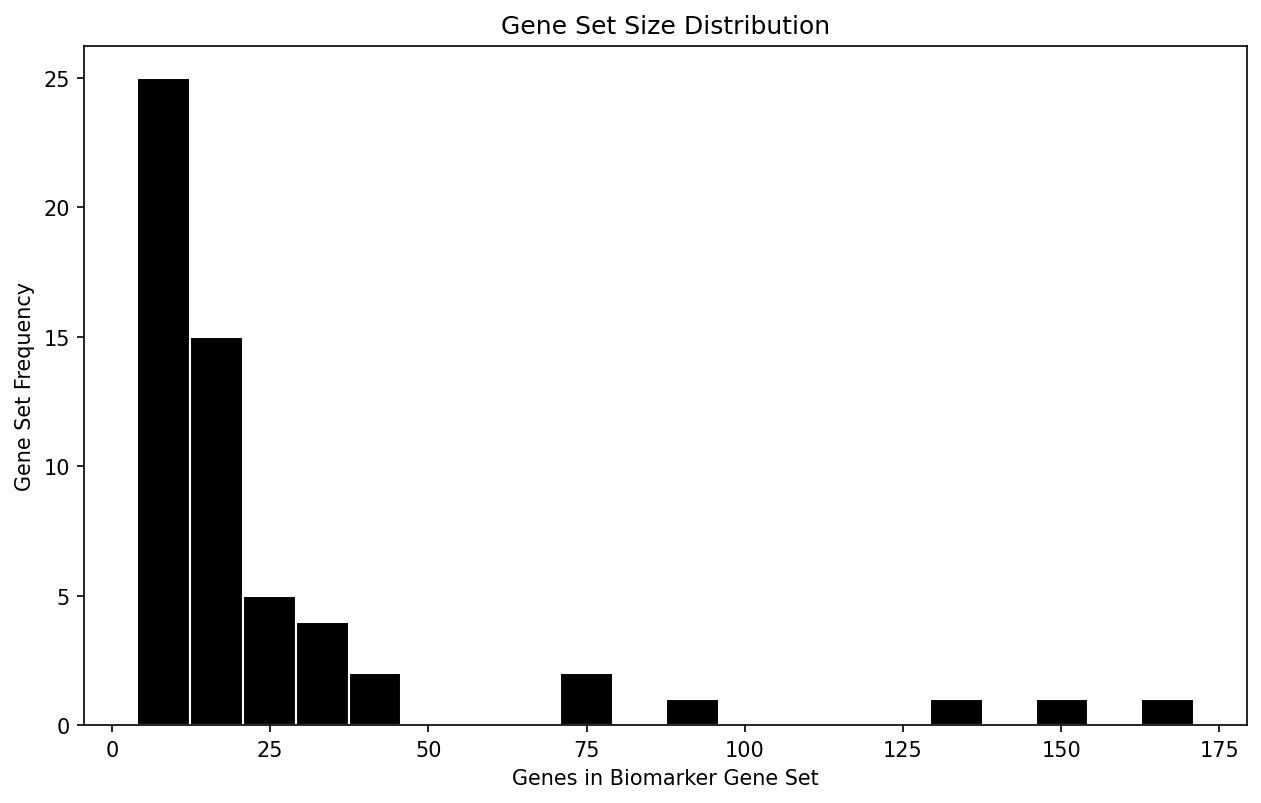

In [115]:
# Creating the histogram without grid lines
plt.figure(figsize=(10, 6))
plt.hist(geneset_size, bins=20, color='black', edgecolor='white')
plt.title('Gene Set Size Distribution')
plt.xlabel('Genes in Biomarker Gene Set')
plt.ylabel('Gene Set Frequency')
plt.show()

In [ ]:
gene_count_dict

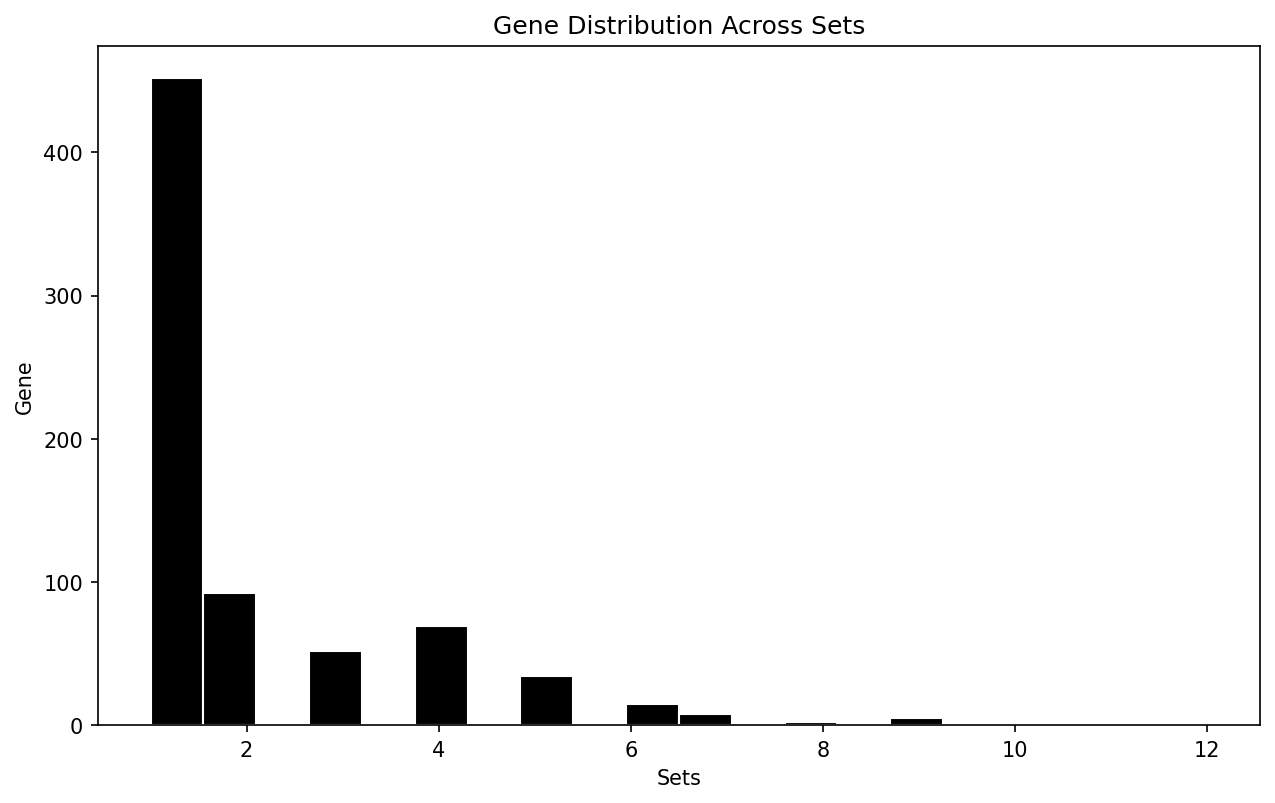

In [116]:
# Creating the histogram without grid lines
plt.figure(figsize=(10, 6))
plt.hist(gene_count_dict.values(), bins=20, color='black', edgecolor='white')
plt.title('Gene Distribution Across Sets')
plt.xlabel('Sets')
plt.ylabel('Gene')
plt.show()

In [120]:
biomarker_role_dict
biomarker_role_dict = dict(sorted(biomarker_role_dict.items(), key=lambda item: item[1]))

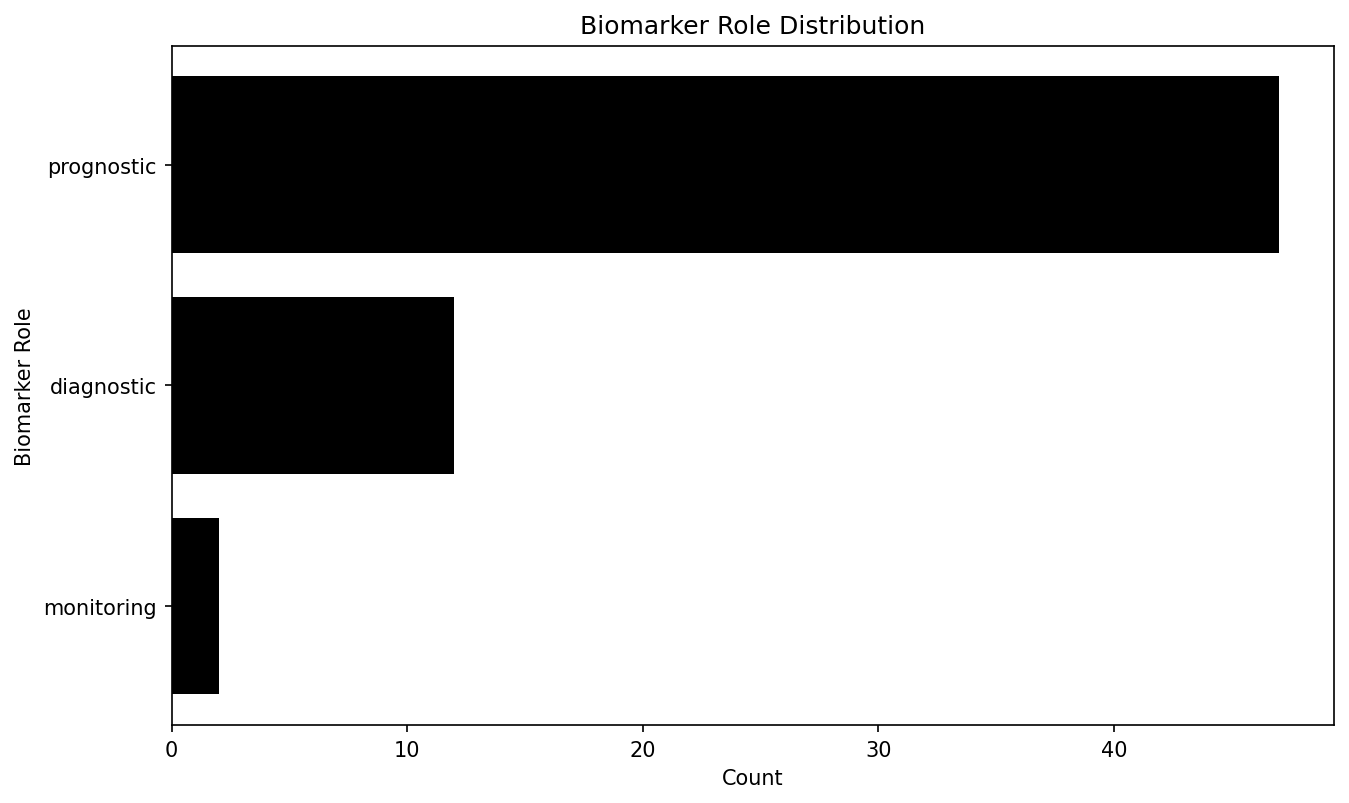

In [121]:
plt.figure(figsize=(10, 6))
plt.barh(list(biomarker_role_dict.keys()), list(biomarker_role_dict.values()), color='black')
plt.title('Biomarker Role Distribution')
plt.xlabel('Count')
plt.ylabel('Biomarker Role')
plt.grid(False)
plt.show()

In [122]:
unique_condition_dict_count = dict(sorted(unique_condition_dict_count.items(), key=lambda item: item[1]))

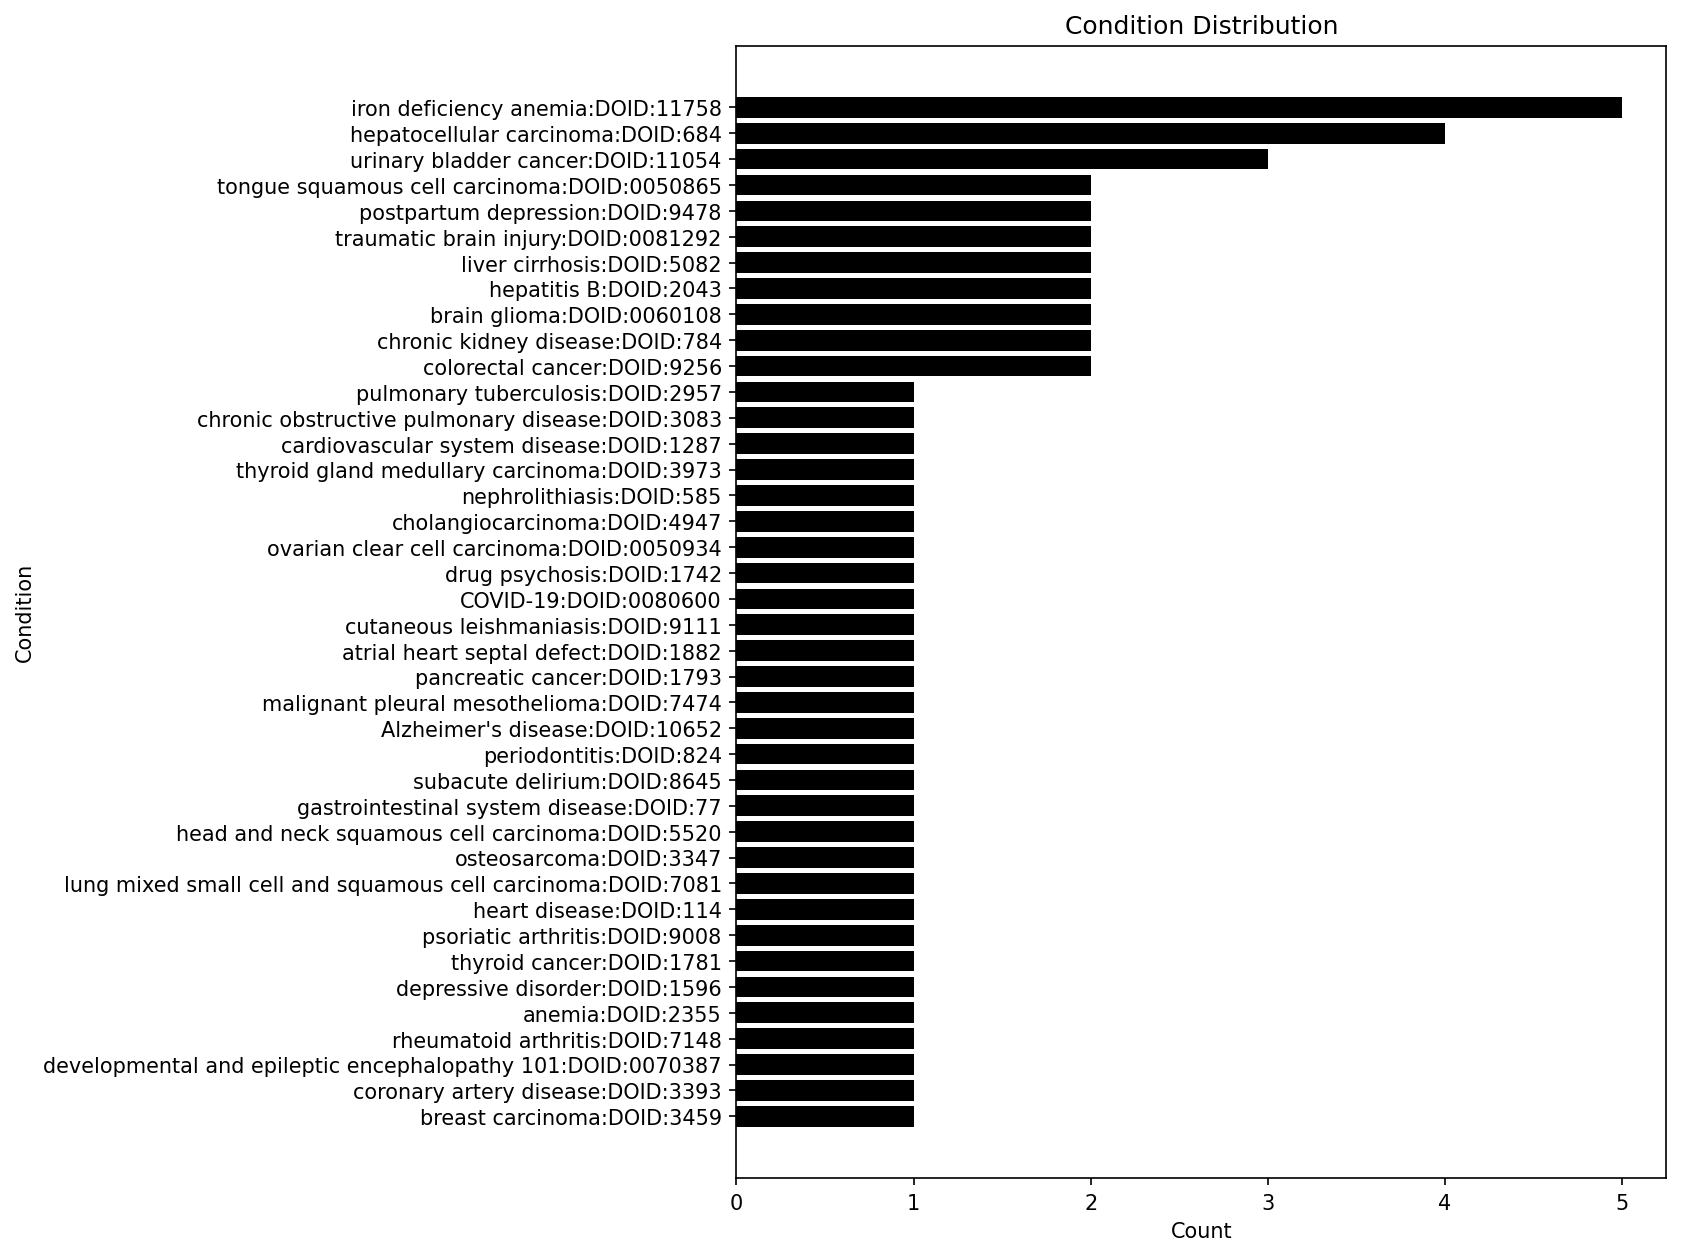

In [124]:
plt.figure(figsize=(8, 10))
plt.barh(list(unique_condition_dict_count.keys()), list(unique_condition_dict_count.values()), color='black')
plt.title('Condition Distribution')
plt.xlabel('Count')
plt.ylabel('Condition')
plt.grid(False)
plt.show()

In [125]:
len(unique_condition_set)

40